# README

* For each observation, divid the sequence to a list of windows of the same size using a moving window of a fix size with a step of 1 or larger.
* ~~Trucate long sequences to match the shortest~~
* In training, use the same nunber of data points for each class. This means throwing away a ton of training data. 

In [1]:
%matplotlib inline
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.models import model_from_json
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
original_features=['scalar.fx', 'scalar.fy', 'scalar.fz','scalar.tx', 'scalar.ty','scalar.tz','scalar.current','scalar.ang_vel']

# Load data

In [3]:
%%time
dfs = [pd.read_csv(filename, sep=',',header=0) for filename in glob.glob("data/*.csv")]

CPU times: user 13.4 s, sys: 636 ms, total: 14 s
Wall time: 14.1 s


## Get the longest and shortest sequences

In [4]:
longest_len = max(dfs, key=lambda df: df.shape[0]).shape[0]
shortest_len = min(dfs, key=lambda df: df.shape[0]).shape[0]
print("shortest_len={}, longest_len={}".format( shortest_len, longest_len) )

shortest_len=535, longest_len=4479


# Create windows

* Windows are equal length comprising of N, eg. 32, time frames.
* A wavelet is obtained by using a moving window of length N.
* The beginning of the moving window starts M, e.g. 8, time frames behind the beginning of the previous window.

In [5]:
def rolling(df, original_features=original_features, 
            frames=32, steps=8, type_class='class.type', stage_class='class.stage'):
    """
    df - dataframe
    """
    starts = np.arange(0, len(df)-frames, steps)[:-1] # an array of start locations    
    x = np.zeros((len(starts), frames, len(original_features)))
    y = np.zeros((len(starts), 1))
    y2 = np.zeros((len(starts), 1))
    
    for i in np.arange(len(starts)):
        start = starts[i]
        x[i] = df.iloc[start:start+frames].as_matrix(columns=original_features)
        y[i] = df[type_class].iloc[start + steps]
        y2[i] = df[stage_class].iloc[start + steps]

    return x, y, y2

In [6]:
def moving_windows(dfs, frames=32, steps=8):
    """split each observation to a tuple of X, Y, Y2 using a moving window"""

    X=None; Y=None; Y2=None
    for df in dfs:
        x, y, y2 = rolling(df, original_features,frames, steps)
        if X is None:
            X = x.copy(); Y = y.copy(); Y2 = y2.copy();
        else:
            X = np.append(X, x, axis=0)
            Y = np.append(Y, y, axis=0)
            Y2= np.append(Y2, y2, axis=0)
    return X, Y, Y2

## save or load window-based data

In [7]:
%%time
frames = 32
steps = 8

import os.path
file_path = 'data_win/f32s8.npz'
if os.path.exists(file_path):
    loaded = np.load(file_path)
    X = loaded['X']
    Y = loaded['Y']
    Y2 = loaded['Y2']
else:
    X, Y, Y2 = moving_windows(dfs, frames, steps)
    np.savez_compressed(file_path, X=X, Y=Y, Y2=Y2)

CPU times: user 4.14 s, sys: 73.9 ms, total: 4.21 s
Wall time: 4.21 s


#### Plot a histogram of types

(array([      0.,  433720.,   82458.,   21594.,    3516.,    2264.,
           6397.,    3243.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 8 Patch objects>)

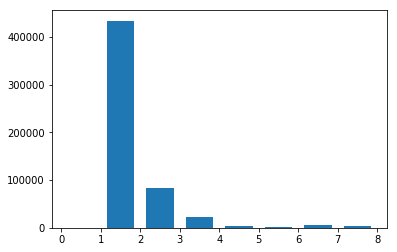

In [8]:
plt.hist(Y, bins=np.arange(len(np.unique(Y))+2), rwidth=.7, align='mid')

In [9]:
np.unique(Y)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.])

#### Plot a histogram of stages

(array([  42954.,   24250.,   30095.,   76401.,  322035.,   10290.,
           2103.,     952.,    2786.,   41326.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

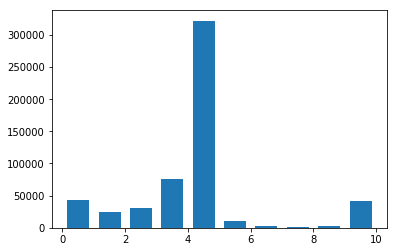

In [10]:
plt.hist(Y2, bins=np.arange(len(np.unique(Y2))+1), rwidth=.7, align='mid')

In [11]:
np.unique(Y2)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

# One hot encoding of dependent variables

In [12]:
offset = 1
num_classes = len(np.unique(Y))
Y_encoded=to_categorical(Y-offset, num_classes=num_classes)
Y_encoded.shape

(553192, 7)

In [13]:
offset = 0
num_classes = len(np.unique(Y2))
Y2_encoded=to_categorical(Y2, num_classes=num_classes)
Y2_encoded.shape

(553192, 10)

# Split the data to train, validation and test

* train = 60%
* validation = 20%
* test = 20%

In [14]:
x_train, x_validate, x_test = np.split(X, [int(.6*len(X)), int(.8*len(X))])
y_train, y_validate, y_test = np.split(Y_encoded, [int(.6*len(Y_encoded)), int(.8*len(Y_encoded))])
y2_train, y2_validate, y2_test = np.split(Y2_encoded, [int(.6*len(Y2_encoded)), int(.8*len(Y2_encoded))])

print (x_train.shape, y_train.shape, y2_train.shape)
print (x_validate.shape, y_validate.shape, y2_validate.shape)
print (x_test.shape, y_test.shape, y2_test.shape)

((331915, 32, 8), (331915, 7), (331915, 10))
((110638, 32, 8), (110638, 7), (110638, 10))
((110639, 32, 8), (110639, 7), (110639, 10))


### Histogram of classes in training data

(array([ 259741.,   47704.,   13477.,    2275.,    1808.,    4118.,    2792.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

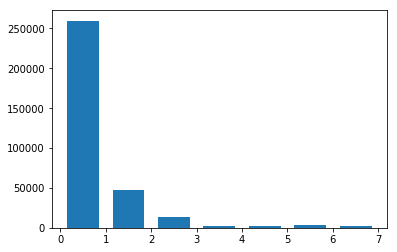

In [15]:
labels=np.argmax(y_train, axis=1)
plt.hist(labels, bins=np.arange(len(np.unique(labels))+1), rwidth=.7, align='mid')

(array([  25840.,   15718.,   18270.,   43892.,  193170.,    6269.,
           1670.,     605.,    1739.,   24742.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

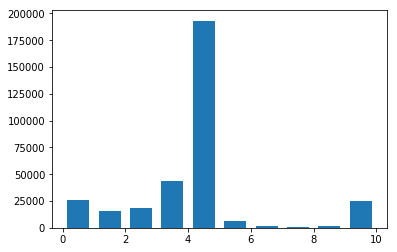

In [16]:
labels=np.argmax(y2_train, axis=1)
plt.hist(labels, bins=np.arange(len(np.unique(labels))+1), rwidth=.7, align='mid')

# Train a type classification model with LSTM

In [203]:
%%time

timesteps = x_train.shape[1]
data_dim = x_train.shape[2]
num_epochs = 2
batch_size = 64
num_classes = y_train.shape[1]

layers = [LSTM(batch_size, return_sequences=True,
               input_shape=(timesteps, data_dim)), 
         LSTM(batch_size, return_sequences=True),
         LSTM(batch_size),
         Dense(num_classes, activation='softmax')]

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential(layers)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_validate, y_validate))

Train on 331915 samples, validate on 110638 samples
Epoch 1/2
331915/331915 [==============================] - 366s 1ms/step - loss: 0.2601 - acc: 0.9207 - val_loss: 0.4082 - val_acc: 0.9085
Epoch 2/2
331915/331915 [==============================] - 366s 1ms/step - loss: 0.1784 - acc: 0.9469 - val_loss: 0.4011 - val_acc: 0.9142
CPU times: user 18min 34s, sys: 1min 33s, total: 20min 7s
Wall time: 12min 14s


## View training history

In [19]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

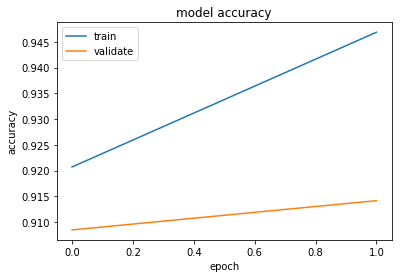

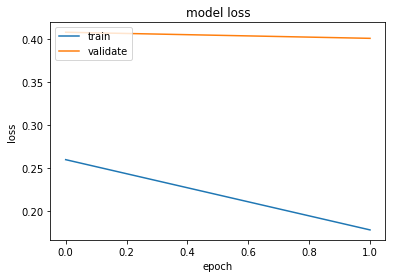

In [223]:
plot_history(history)

## Save the model
include the model and its weights

In [22]:
def save_model(model, model_filename="models/type_lstm_v2.json", weights_file_name="models/type_lstm_v2.h5"):
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_filename, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(weights_file_name)
    print("Saved the model to disk")

In [208]:
save_model(model, "models/type_lstm_v2.json", "models/type_lstm_v2.h5")

Saved the model to disk


## Use the saved model to predict on new data

In [25]:
def load_model(model_filename='models/type_lstm_v2.json', weights_filename="models/type_lstm_v2.h5"):
    # load json and create model
    json_file = open(model_filename, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weights_filename)
    print("Loaded the model from disk")
    
    return loaded_model

In [211]:
model = load_model('models/type_lstm_v2.json', "models/type_lstm_v2.h5")

Loaded the model from disk


## We need to compile the model before use it

In [213]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Evaluation

display labels for the scalar outputs

In [214]:
model.metrics_names

['loss', 'acc']

In [215]:
score = model.evaluate(x_test, y_test, batch_size=64)

110639/110639 [==============================] - 27s 246us/step


In [216]:
score

[0.58703763481808136, 0.88250978407252412]

## Predict

**Remember** The classes are 0 to 6 instead of 1 to 7.

In [217]:
%%time
y_hat = model.predict(x_test)

CPU times: user 55 s, sys: 912 ms, total: 55.9 s
Wall time: 52.1 s


In [218]:
x_test.shape

(110639, 32, 8)

### Prediction results are the probability of each class

In [221]:
y_hat.shape

(110639, 7)

In [222]:
y_hat

array([[  9.65558589e-01,   2.59931013e-02,   7.62081845e-03, ...,
          8.81362575e-06,   2.99565814e-04,   1.20917277e-04],
       [  9.08049345e-01,   8.79234746e-02,   2.83322064e-03, ...,
          1.37809475e-05,   6.29237504e-04,   1.32694418e-04],
       [  2.21656829e-01,   7.68357635e-01,   2.72855023e-03, ...,
          1.43685596e-04,   5.94452303e-03,   7.39601557e-04],
       ..., 
       [  9.98853207e-01,   2.85332091e-04,   5.26196964e-05, ...,
          8.07839184e-10,   1.10939745e-05,   1.29518530e-05],
       [  9.98848319e-01,   2.89355608e-04,   5.32317790e-05, ...,
          8.23479285e-10,   1.11304389e-05,   1.29263944e-05],
       [  9.98844743e-01,   2.92259938e-04,   5.37172309e-05, ...,
          8.31105629e-10,   1.11812869e-05,   1.29253995e-05]], dtype=float32)

# Train a stage classification model with LSTM

In [17]:
%%time

timesteps = x_train.shape[1]
data_dim = x_train.shape[2]
num_epochs = 2
batch_size = 64
num_classes = y2_train.shape[1]

layers = [LSTM(batch_size, return_sequences=True,
               input_shape=(timesteps, data_dim)), 
         LSTM(batch_size, return_sequences=True),
         LSTM(batch_size),
         Dense(num_classes, activation='softmax')]

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential(layers)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(x_train, y2_train,
          batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_validate, y2_validate))

Train on 331915 samples, validate on 110638 samples
Epoch 1/2
331915/331915 [==============================] - 370s 1ms/step - loss: 0.2590 - acc: 0.9182 - val_loss: 0.3623 - val_acc: 0.9080
Epoch 2/2
331915/331915 [==============================] - 369s 1ms/step - loss: 0.1365 - acc: 0.9548 - val_loss: 0.3563 - val_acc: 0.9163
CPU times: user 18min 30s, sys: 1min 15s, total: 19min 46s
Wall time: 12min 20s


## View training history

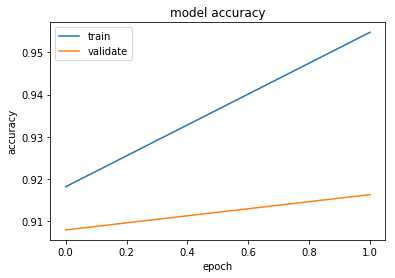

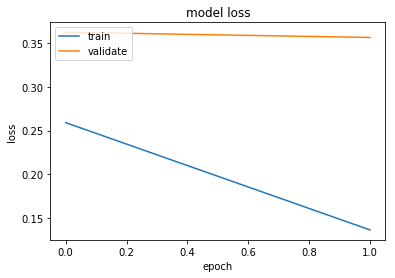

In [20]:
plot_history(history)

## Save the model
include the model and its weights

In [23]:
save_model(model, "models/stage_lstm_v2.json", "models/stage_lstm_v2.h5")

Saved the model to disk


## Use the saved model to predict on new data

In [26]:
model = load_model('models/stage_lstm_v2.json', "models/stage_lstm_v2.h5")

Loaded the model from disk


## We need to compile the model before use it

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Evaluation

display labels for the scalar outputs

In [28]:
model.metrics_names

['loss', 'acc']

In [29]:
score = model.evaluate(x_test, y2_test, batch_size=64)

110639/110639 [==============================] - 28s 252us/step


In [30]:
score

[0.36901070108999057, 0.90858558013104973]

## Predict

In [31]:
%%time
y_hat = model.predict(x_test)

CPU times: user 56.6 s, sys: 830 ms, total: 57.4 s
Wall time: 53.5 s


In [32]:
x_test.shape

(110639, 32, 8)

### Prediction results are the probability of each class

In [33]:
y_hat.shape

(110639, 10)

In [34]:
y_hat

array([[  1.79879731e-04,   3.08321952e-03,   1.77897280e-03, ...,
          3.66013001e-06,   2.13543186e-04,   2.51997937e-03],
       [  1.86638383e-04,   2.78232712e-03,   1.33088825e-03, ...,
          2.51796428e-06,   2.18545392e-04,   2.93292059e-03],
       [  3.38611047e-04,   2.10224418e-03,   6.59144076e-04, ...,
          2.76826040e-06,   7.18989817e-04,   1.99226197e-03],
       ..., 
       [  7.10208667e-07,   1.99685815e-06,   2.47788853e-06, ...,
          3.28502097e-06,   5.41088002e-06,   9.99902010e-01],
       [  7.06874971e-07,   1.98989210e-06,   2.47511230e-06, ...,
          3.30794387e-06,   5.42267617e-06,   9.99902487e-01],
       [  7.09224878e-07,   1.99271949e-06,   2.48745982e-06, ...,
          3.34906963e-06,   5.44990507e-06,   9.99902487e-01]], dtype=float32)